In [1]:
import os
import warnings
base_path = os.path.abspath("../")
os.chdir(base_path)
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import eli5
import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [5]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

In [6]:
feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']  # specify feature names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

## S Learner

In [7]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.5411375])

In [8]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [9]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.434451
 stars         0.387973
 quixotic      0.075904
 fireman       0.050378
 merciful      0.045804
 lethal        0.000747
 touch         0.000584
 change        0.000311
 adhesive      0.000289
 future        0.000262
 offer         0.000256
 eight         0.000252
 dependent     0.000250
 rigid         0.000246
 shelf         0.000240
 damp          0.000236
 cute          0.000231
 wrap          0.000219
 rain          0.000217
 barbarous     0.000211
 clammy        0.000208
 nonchalant    0.000200
 playground    0.000192
 sweltering    0.000168
 lip           0.000167
 dtype: float64}

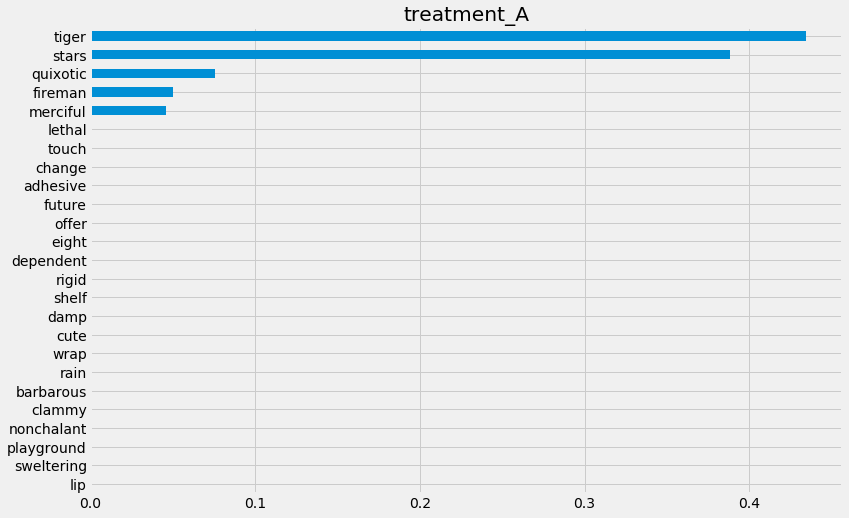

In [10]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [11]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
#                         model_tau_feature=model_tau, 
                        method='permutation', 
                        features=feature_names)

{'treatment_A': tiger         0.960084
 stars         0.827105
 quixotic      0.178907
 fireman       0.117468
 merciful      0.084850
 lethal        0.000925
 touch         0.000437
 future        0.000146
 rain          0.000108
 shelf         0.000069
 clammy        0.000064
 playground    0.000047
 cute          0.000037
 nonchalant    0.000033
 adhesive      0.000027
 barbarous     0.000025
 dependent     0.000024
 sweltering    0.000018
 damp          0.000014
 offer         0.000012
 rigid        -0.000011
 wrap         -0.000029
 lip          -0.000031
 change       -0.000063
 eight        -0.000070
 dtype: float64}

In [12]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
#                         model_tau_feature=model_tau, 
                        method='permutation', 
                        features=feature_names)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 3.2569940090179443 seconds


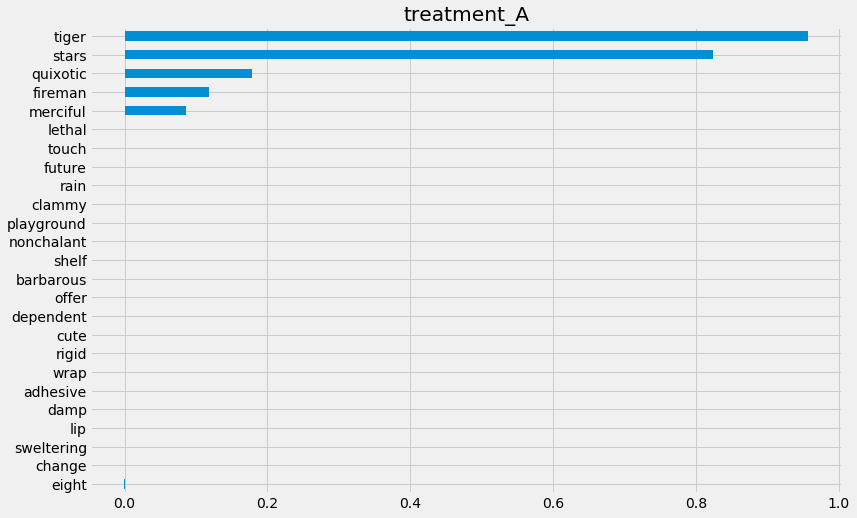

In [13]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
#                          model_tau_feature=model_tau, 
                         method='permutation', 
                         features=feature_names)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [14]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.8739352226257324 seconds


In [15]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         9.858132e-01
stars         8.321294e-01
quixotic      1.828191e-01
fireman       1.184799e-01
merciful      8.616750e-02
lethal        7.603594e-04
touch         5.231986e-04
future        1.973165e-04
change        1.632739e-04
adhesive      1.337985e-04
cute          1.077212e-04
rain          1.066100e-04
damp          9.619388e-05
lip           9.535538e-05
rigid         8.841384e-05
nonchalant    8.626285e-05
offer         5.966767e-05
wrap          5.768970e-05
barbarous     3.069333e-05
eight         1.563907e-05
dependent     6.796567e-06
clammy        6.842333e-07
sweltering   -1.288040e-05
shelf        -1.402867e-05
playground   -4.500050e-05
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

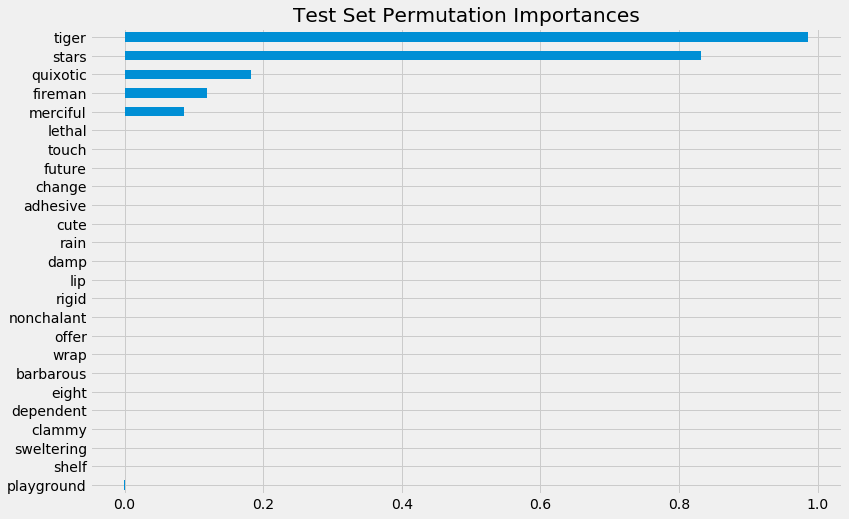

In [16]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [17]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

tiger         0.946529
stars         0.834437
quixotic      0.183458
fireman       0.121298
merciful      0.085366
future        0.002076
lethal        0.001622
rain          0.001338
touch         0.001304
playground    0.001188
shelf         0.001088
change        0.000892
cute          0.000880
nonchalant    0.000768
dependent     0.000738
damp          0.000672
eight         0.000653
barbarous     0.000638
sweltering    0.000614
rigid         0.000611
wrap          0.000582
lip           0.000461
adhesive      0.000454
clammy        0.000316
offer         0.000293
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

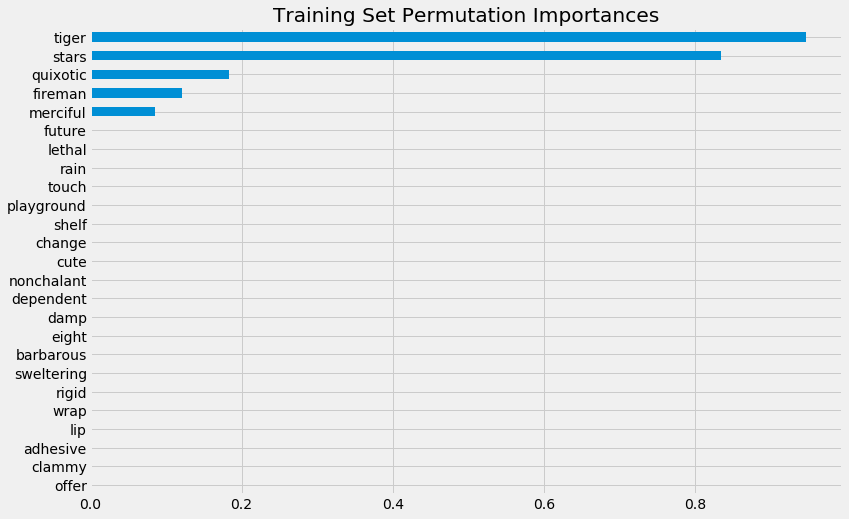

In [18]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [19]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[ 9.54920642e-02,  1.37374082e-02,  1.33279336e-02, ...,
         -2.06871177e-03, -2.66076132e-04,  1.30579510e-03],
        [ 1.52554243e-01,  9.41346797e-02,  1.49063770e-02, ...,
          6.93992611e-04, -3.32145183e-04,  4.38637969e-04],
        [ 1.22574946e-01, -1.25553817e-01,  7.88531120e-03, ...,
          5.12842184e-04, -5.33488940e-05,  4.21378025e-04],
        ...,
        [ 4.29900990e-02,  4.61323097e-02, -1.94488735e-02, ...,
          5.88272113e-04, -6.99578975e-05, -5.21623423e-04],
        [ 9.68880966e-02,  1.60017289e-01, -2.16130055e-02, ...,
          2.32931550e-03,  3.80467240e-04,  1.94737081e-04],
        [ 1.16276020e-01,  1.68063449e-01, -2.00803169e-02, ...,
         -1.55301091e-02,  3.36448146e-05, -9.34100537e-05]])}

In [20]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([0.12503768, 0.13682801, 0.02568389, 0.03708587, 0.03641674,
       0.00069041, 0.00068193, 0.0019609 , 0.00022468, 0.00026392,
       0.00067809, 0.00087176, 0.00025074, 0.0007421 , 0.00120813,
       0.00041733, 0.00040425, 0.00043008, 0.00080497, 0.00021201,
       0.00035384, 0.00035859, 0.00158597, 0.00036984, 0.00075101])

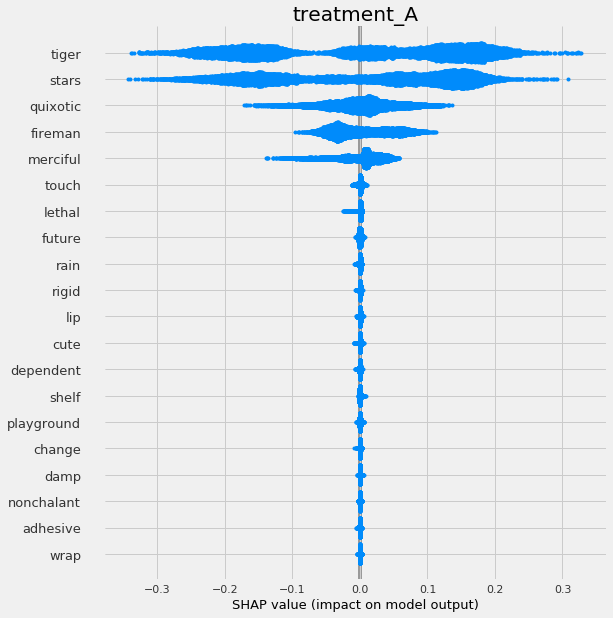

In [21]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

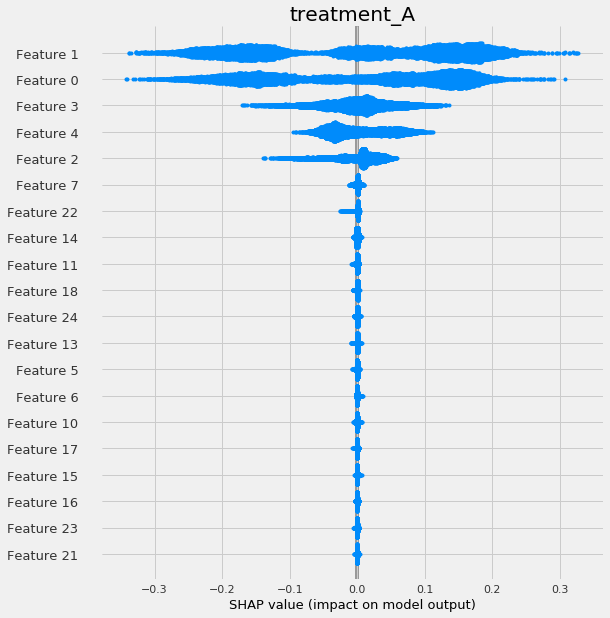

In [22]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(shap_dict=shap_slearner)

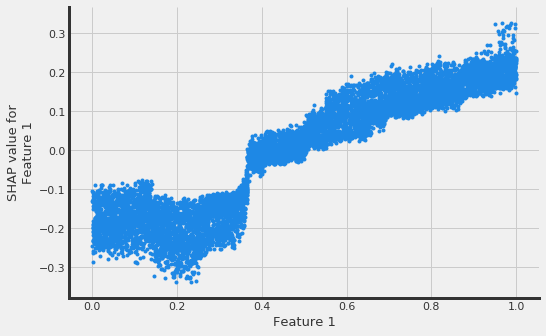

In [23]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

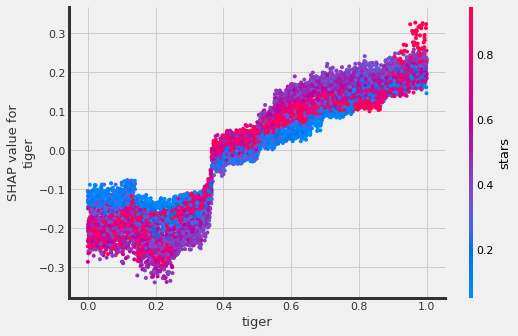

In [24]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='tiger',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

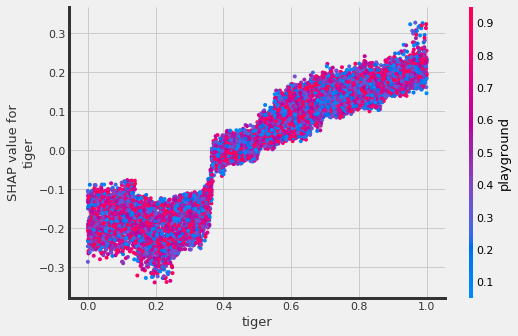

In [25]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=10,
                              shap_dict=shap_slearner, 
                              features=feature_names)

## T Learner

In [26]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([0.54576859]), array([0.53103723]), array([0.56049995]))

In [27]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

### Feature Importance (method = `auto`)

In [28]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.338486
 stars         0.289171
 quixotic      0.064260
 fireman       0.039061
 merciful      0.037456
 lip           0.017477
 playground    0.016479
 damp          0.014931
 sweltering    0.014510
 dependent     0.014461
 change        0.014072
 lethal        0.013496
 eight         0.012584
 barbarous     0.011806
 cute          0.011514
 offer         0.011075
 touch         0.010971
 adhesive      0.010577
 rain          0.010225
 clammy        0.009678
 nonchalant    0.009372
 shelf         0.007618
 rigid         0.007612
 future        0.007579
 wrap          0.005527
 dtype: float64}

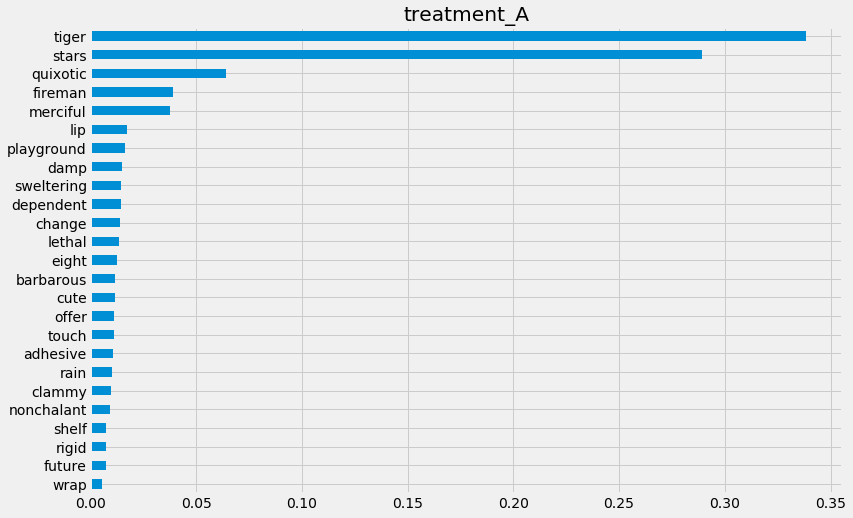

In [29]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [30]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        method='permutation', 
                        features=feature_names)

{'treatment_A': tiger         0.530249
 stars         0.446080
 quixotic      0.071683
 fireman       0.040408
 merciful      0.029755
 playground    0.012686
 lip           0.011915
 sweltering    0.010679
 lethal        0.009569
 change        0.009231
 dependent     0.008712
 damp          0.007067
 cute          0.006732
 clammy        0.006303
 offer         0.006272
 eight         0.005442
 adhesive      0.005085
 rain          0.004724
 barbarous     0.004632
 touch         0.004338
 nonchalant    0.004221
 shelf         0.004027
 wrap          0.002561
 future        0.002229
 rigid         0.001888
 dtype: float64}

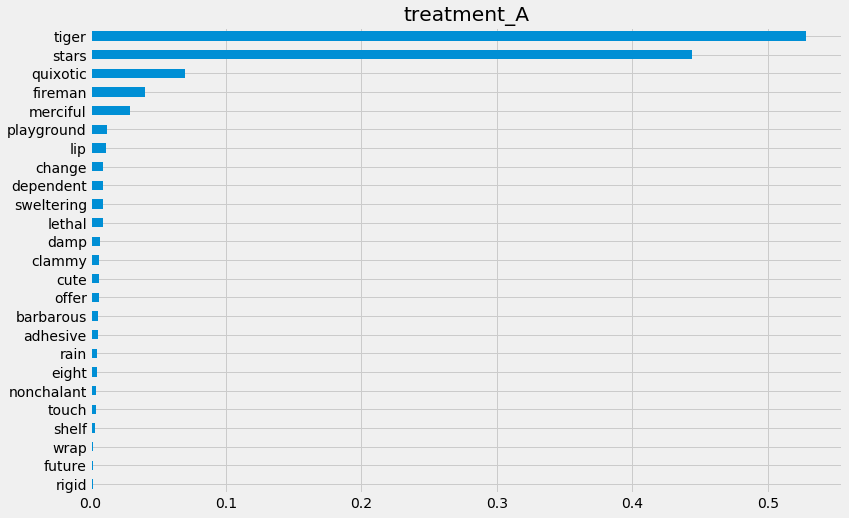

In [31]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         method='permutation', 
                         features=feature_names)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [32]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.036790132522583 seconds


In [33]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.536672
stars         0.450641
quixotic      0.067470
fireman       0.043405
merciful      0.025300
lethal        0.011755
lip           0.010349
sweltering    0.009283
cute          0.009235
playground    0.008435
damp          0.007876
dependent     0.007405
change        0.006321
adhesive      0.005640
offer         0.005372
touch         0.005267
barbarous     0.004881
rain          0.004858
eight         0.004790
clammy        0.002990
wrap          0.002913
future        0.002887
nonchalant    0.002528
shelf         0.002386
rigid         0.001678
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

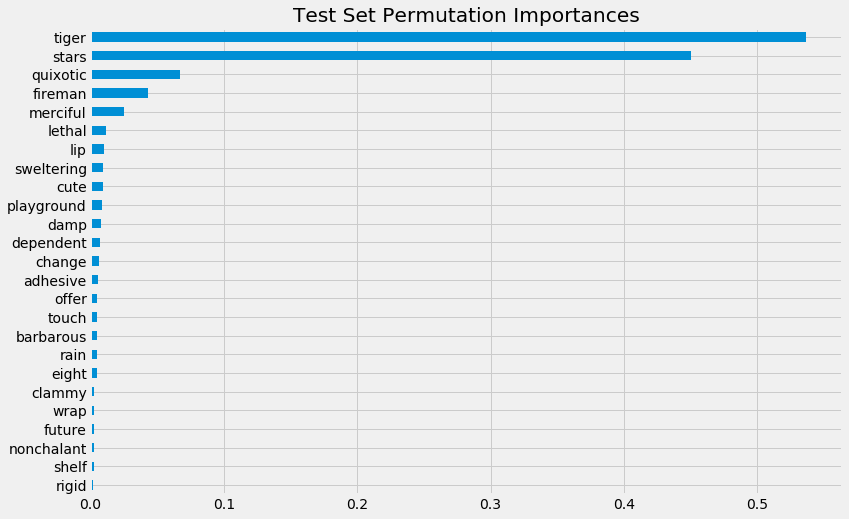

In [34]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [35]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_A': array([[ 0.07411302,  0.02126577, -0.0005052 , ..., -0.02705496,
         -0.018592  ,  0.01280403],
        [ 0.18826401,  0.08567725,  0.01421674, ...,  0.00374922,
         -0.00375862,  0.00594528],
        [ 0.10672545, -0.13817747, -0.00637039, ...,  0.00834131,
          0.01356586,  0.00240405],
        ...,
        [-0.01410772, -0.00162628,  0.00746144, ...,  0.00938076,
          0.00669372, -0.06410688],
        [ 0.09843179,  0.16299099, -0.01850317, ...,  0.00173639,
          0.02289434,  0.01337524],
        [ 0.14121005,  0.22862074, -0.02999897, ..., -0.03946236,
          0.0196476 ,  0.01587297]])}

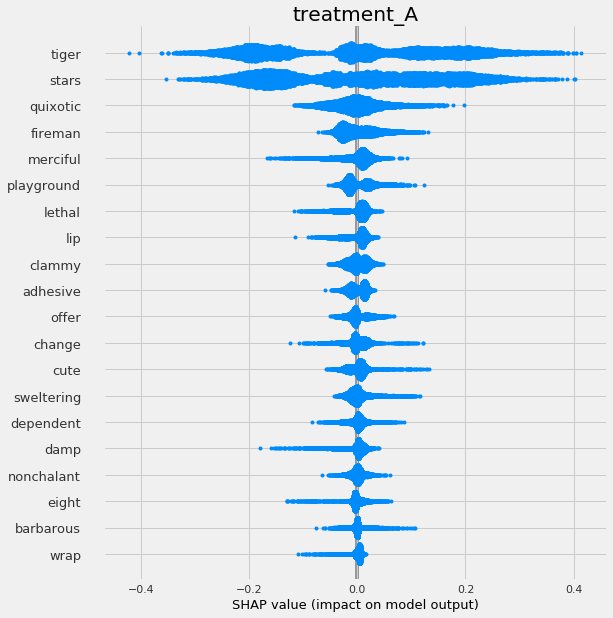

In [36]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

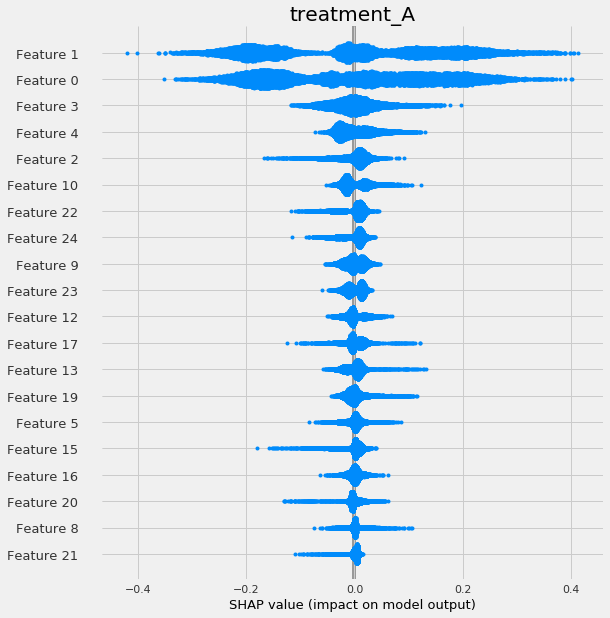

In [37]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(shap_dict=shap_tlearner)

## X Learner

In [38]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, e_multi, w_multi, y)

(array([0.49349338]), array([0.47962647]), array([0.50736028]))

In [39]:
xlearner_tau = xlearner.predict(X, e_multi, w_multi, y)

### Feature Importance (method = `auto`)

In [40]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': tiger         0.441616
 stars         0.294535
 quixotic      0.021909
 merciful      0.019754
 fireman       0.019411
 dependent     0.019051
 lip           0.016936
 lethal        0.015544
 sweltering    0.015418
 playground    0.013337
 cute          0.011529
 change        0.011232
 offer         0.010431
 clammy        0.010345
 touch         0.010127
 damp          0.009452
 eight         0.008768
 adhesive      0.007844
 rain          0.007808
 wrap          0.006668
 barbarous     0.006078
 rigid         0.005888
 future        0.005790
 nonchalant    0.005633
 shelf         0.004897
 dtype: float64}

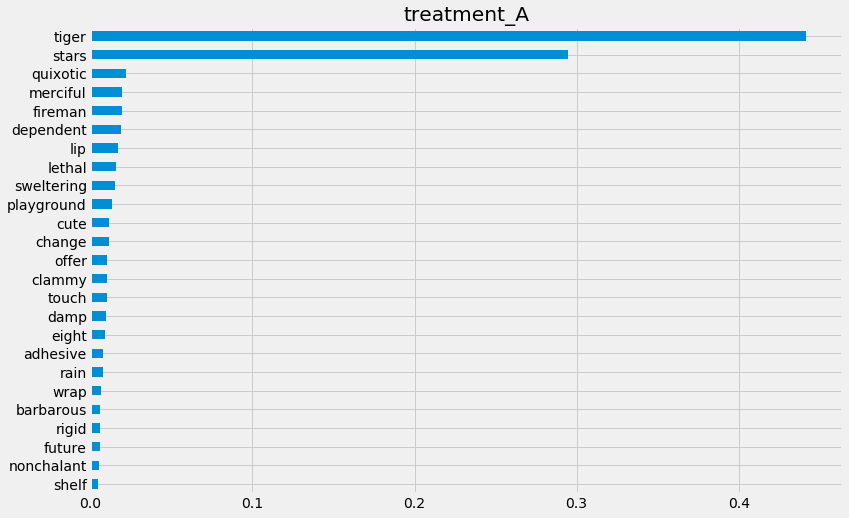

In [41]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [42]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names)

{'treatment_A': tiger         0.781777
 stars         0.547834
 quixotic      0.027457
 dependent     0.026388
 merciful      0.020745
 fireman       0.019868
 lip           0.019507
 playground    0.018063
 lethal        0.017809
 sweltering    0.016216
 cute          0.013806
 change        0.011297
 offer         0.011085
 clammy        0.011040
 touch         0.009261
 damp          0.008775
 eight         0.007209
 adhesive      0.006895
 rain          0.005756
 nonchalant    0.004745
 barbarous     0.004733
 wrap          0.004459
 rigid         0.004340
 shelf         0.003164
 future        0.003065
 dtype: float64}

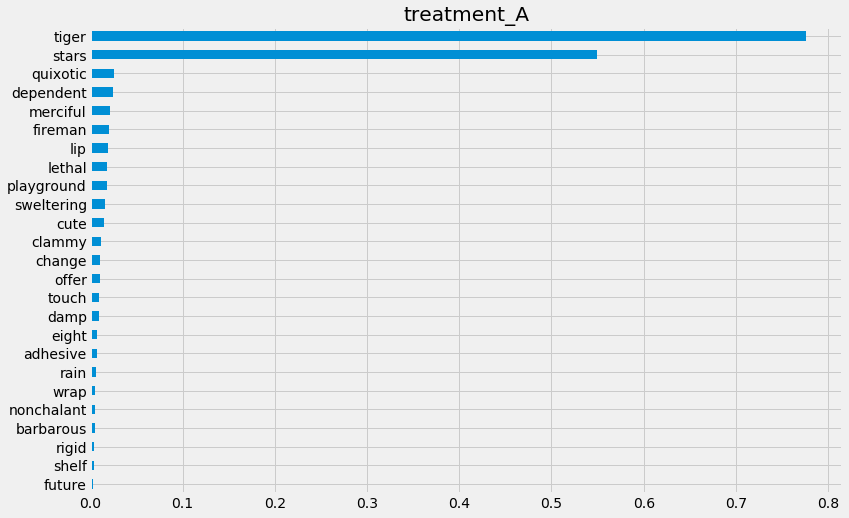

In [43]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [44]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.1682038307189941 seconds


In [45]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.827813
stars         0.545228
dependent     0.030324
quixotic      0.028407
merciful      0.024195
lip           0.023630
fireman       0.020935
lethal        0.019944
playground    0.019223
sweltering    0.016497
cute          0.014906
change        0.011769
clammy        0.010827
offer         0.010223
damp          0.009543
eight         0.008394
touch         0.008350
rain          0.007006
adhesive      0.006969
nonchalant    0.006044
wrap          0.005133
rigid         0.003890
barbarous     0.003512
shelf         0.003360
future        0.002925
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

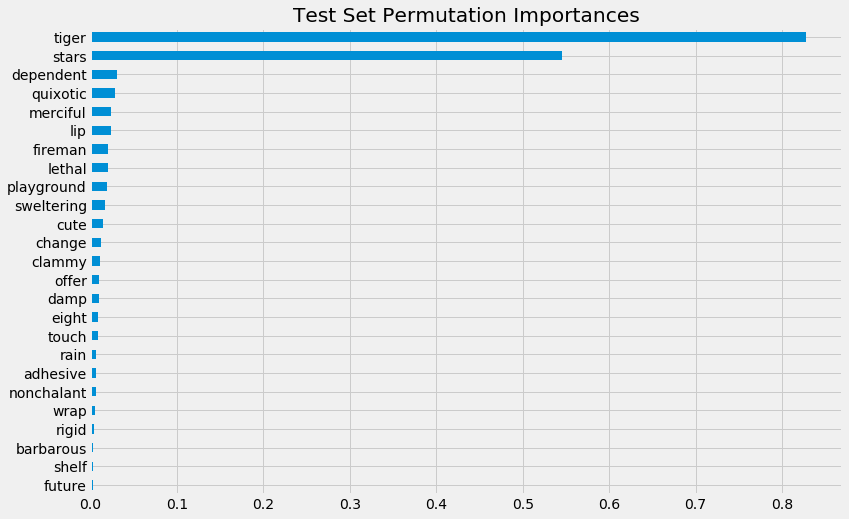

In [46]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [47]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_A': array([[ 0.06489283, -0.01817071, -0.00179379, ..., -0.03593433,
         -0.02352841,  0.00813906],
        [ 0.13569342,  0.03031179,  0.01905418, ...,  0.00621839,
         -0.00105754, -0.00958776],
        [ 0.11946049, -0.10087516, -0.00026981, ...,  0.00819442,
          0.00921944,  0.01140185],
        ...,
        [-0.00253526, -0.03621406, -0.00236821, ...,  0.00806474,
          0.01023206, -0.05835782],
        [ 0.017099  ,  0.09200023, -0.05561374, ...,  0.00372369,
          0.01114021,  0.01218767],
        [ 0.18752789,  0.22661228, -0.04552373, ..., -0.0518559 ,
          0.00934947,  0.01242065]])}

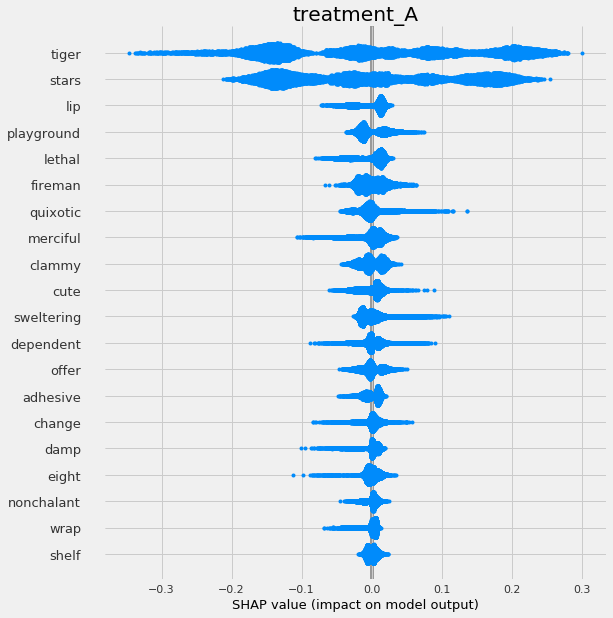

In [48]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

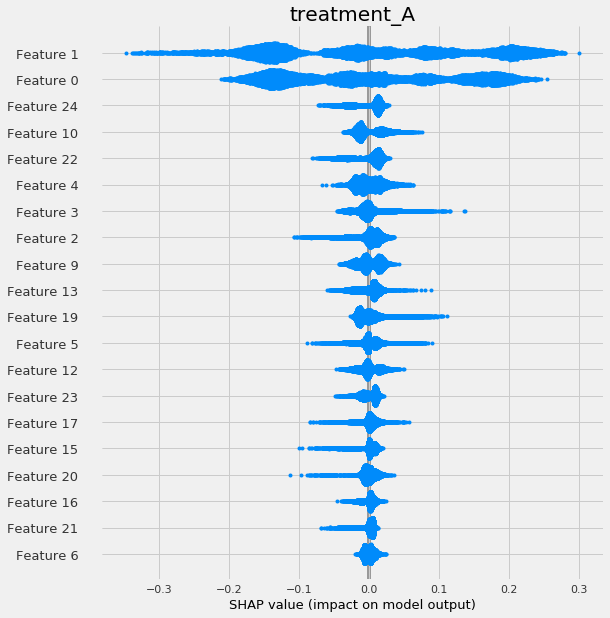

In [49]:
# shap_dict specified
xlearner.plot_shap_values(shap_dict=shap_xlearner)

## R Learner

In [50]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, e_multi, w_multi, y)

### Feature Importance (method = `auto`)

In [51]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


{'treatment_A': cute          0.052667
 nonchalant    0.049000
 stars         0.048000
 lip           0.046333
 eight         0.045333
 sweltering    0.044000
 merciful      0.043667
 change        0.041667
 offer         0.041333
 tiger         0.040000
 rigid         0.039667
 shelf         0.038000
 fireman       0.038000
 adhesive      0.037667
 clammy        0.037667
 wrap          0.037333
 dependent     0.037000
 rain          0.036667
 quixotic      0.036333
 future        0.036000
 playground    0.035667
 touch         0.035333
 barbarous     0.035000
 lethal        0.034000
 damp          0.033667
 dtype: float64}

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


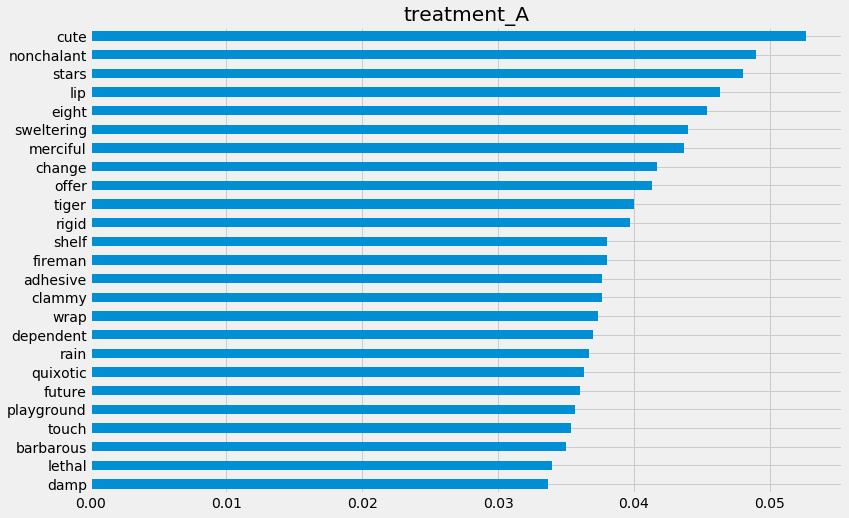

In [52]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='auto', 
                         features=feature_names)

### Feature Importance (method = `permutation`)

In [53]:
rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names)

{'treatment_A': tiger         0.425485
 stars         0.362662
 lip           0.125503
 cute          0.086967
 adhesive      0.086609
 fireman       0.085008
 change        0.084315
 offer         0.083750
 merciful      0.081019
 wrap          0.076769
 rigid         0.076427
 nonchalant    0.075839
 dependent     0.069316
 playground    0.068553
 touch         0.065172
 eight         0.064644
 damp          0.060282
 barbarous     0.058746
 clammy        0.056026
 sweltering    0.055596
 quixotic      0.053484
 lethal        0.052826
 shelf         0.050199
 rain          0.048762
 future        0.041576
 dtype: float64}

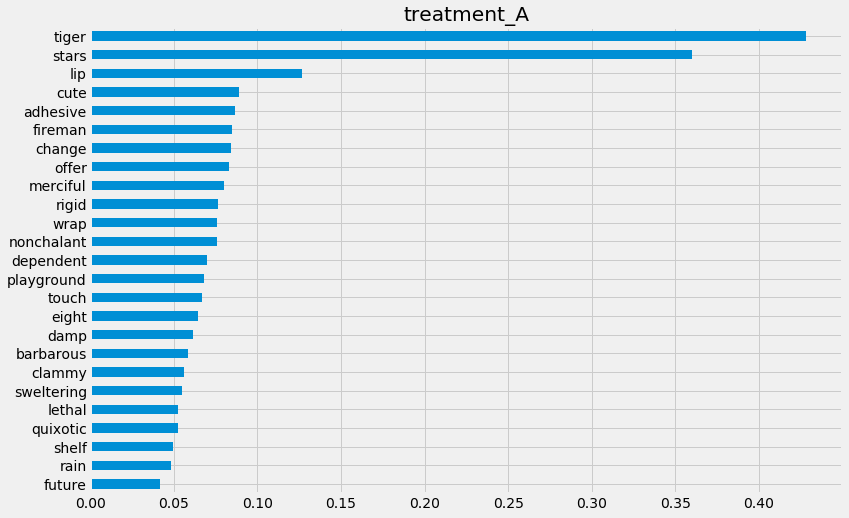

In [54]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names)

### Feature Importance (`sklearn.inspection.permutation_importance`)

In [55]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, rlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.1029951572418213 seconds


In [56]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

tiger         0.291120
stars         0.248765
change        0.037575
cute          0.030178
lip           0.027031
lethal        0.019920
touch         0.018146
adhesive      0.017819
dependent     0.017478
wrap          0.017210
clammy        0.015776
eight         0.015322
nonchalant    0.015080
damp          0.014931
fireman       0.014720
sweltering    0.013679
offer         0.013673
merciful      0.013155
playground    0.012818
quixotic      0.010600
rigid         0.009805
barbarous     0.008429
shelf         0.005775
rain          0.004456
future        0.003481
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

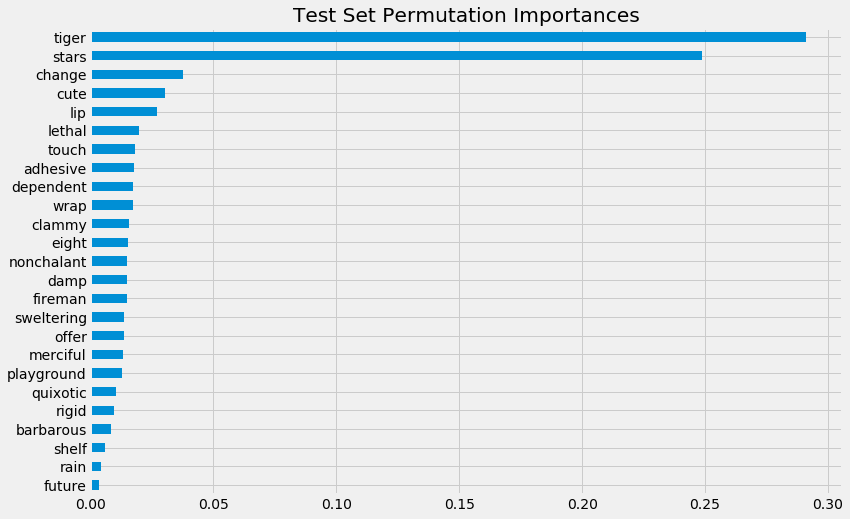

In [57]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [58]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'treatment_A': array([[ 5.30519183e-02, -3.80956165e-02,  9.07086602e-03, ...,
         -5.48105991e-02, -3.45855871e-02,  1.79174514e-02],
        [ 1.89775054e-01,  3.00542328e-02,  8.81204574e-03, ...,
          1.48318217e-02,  2.43515924e-03,  1.06340614e-02],
        [ 9.17609284e-02, -1.39962886e-01,  3.73860356e-05, ...,
          1.63965812e-02,  8.74189482e-03,  1.91223995e-02],
        ...,
        [-3.04950837e-02, -4.25631301e-02, -2.05444872e-03, ...,
          1.34255924e-02,  1.21239951e-02, -8.49646754e-02],
        [ 1.64923901e-03,  8.71570470e-02, -3.76166082e-02, ...,
          4.21868632e-04,  1.19540952e-02,  1.09043569e-02],
        [ 1.31001912e-01,  1.47831982e-01, -3.10560501e-02, ...,
         -4.97635219e-02,  1.36730787e-02,  2.01657442e-02]])}

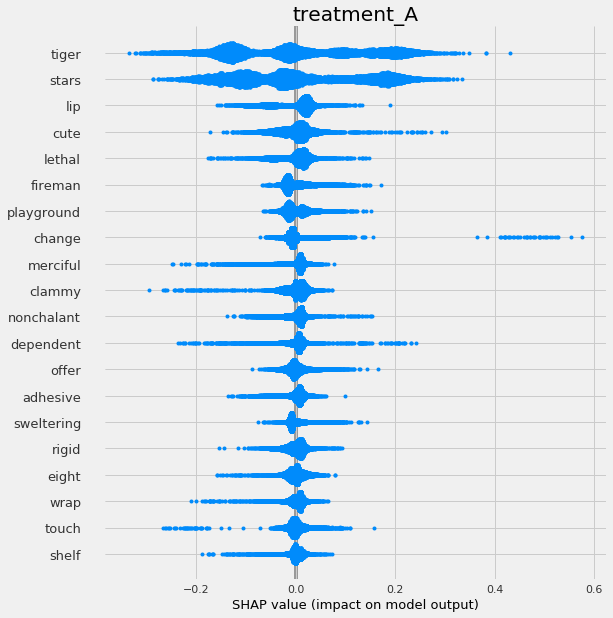

In [59]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

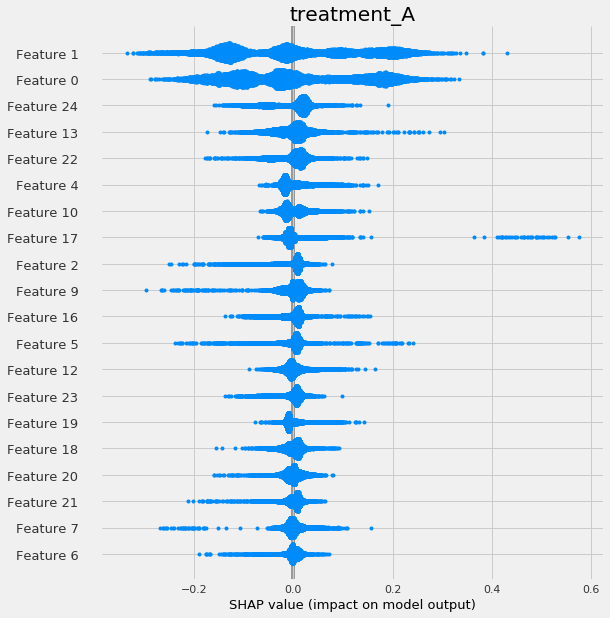

In [60]:
# with providing shap_dict
rlearner.plot_shap_values(shap_dict=shap_rlearner)